In [45]:
import os
from tvb.simulator.lab import *
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
LOG = get_logger('demo')
import pickle as cPickle
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from os.path import join as pjoin
from sklearn import preprocessing
import scipy

### General workflow of data analyses

1. load fmri simulation
2. calculate the fc then calculate the correlation between simulated fc and empirical fc
3. save the correlation coefficient then plot the correlation trajectory for each participant
4. visualize the results

In [46]:
base_dir = "/Users/yilewang/Downloads/"
data_dir = pjoin(base_dir, "local_inhibition_fc_0.001_0.1")

eFC_dir = "/Users/yilewang/workspaces/data4project/lateralization/ts_fmri/fmri_AAL_16"

def FC_fitting(group, caseid, K21, dir):
    subj_dir = pjoin(dir, group, caseid+'_'+str(K21)+'.csv')
    s_ts = pd.read_csv(subj_dir)
    # calculate the simulated FC
    s_fc = s_ts.corr()
    # compare it to the empirical FC
    mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
    e_ts = pd.DataFrame(mat['ROISignals'])
    e_fc = e_ts.corr()
    # vectorize the lower triangle of the matrix
    s_fc_vec = np.tril(s_fc, k=-1).flatten()
    s_fc_vec = s_fc_vec[np.nonzero(s_fc_vec)[0]]
    e_fc_vec = np.tril(e_fc, k=-1).flatten()
    e_fc_vec = e_fc_vec[np.nonzero(e_fc_vec)[0]]
    # calculate the correlation coefficienv
    # s_fc_vec_nor = preprocessing.normalize(np.array(s_fc_vec).reshape(-1,1))[:,0]
    # e_fc_vec_nor = preprocessing.normalize(np.array(e_fc_vec).reshape(-1,1))[:,0]
    corr, p_value = scipy.stats.pearsonr(s_fc_vec, e_fc_vec)
    # iterate then I can have a plot for inidividuals.
    return corr, p_value

In [47]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# create a dataframe for all subjects
local_inhibition = pd.DataFrame(columns=['group', 'caseid', 'highest_K21', 'highest_corr', "highest_p"])
for i, j, go in zip(mega_data.group, mega_data.caseid, mega_data.Go):
    k_corr = []
    for k in np.arange(0.001, 0.1, 0.001):
        k = round(k, 3)
        corr,p_value = FC_fitting(i, j, k, data_dir)
        k_corr.append(corr)
    # find the highest correlation coefficient
    if len(k_corr)>0:
        highest_K21 = np.arange(0.001, 0.1, 0.001)[np.argmax(k_corr)]
        highest_corr = np.max(k_corr)
        highest_p = p_value
        local_inhibition.loc[len(local_inhibition)] = [i, j, highest_K21, highest_corr, p_value]
    else:
        pass
    # if len(k_corr)>0:
    #     plt.plot(k_corr)
    #     plt.title(f"{i}_{j}")
    #     # set the y-axis limit
    #     plt.show()
    # else:
    #     pass

In [48]:
print(local_inhibition)
local_inhibition.to_csv('/Users/yilewang/Desktop/local_inhibition_go_K21.csv', index=False)

   group caseid  highest_K21  highest_corr     highest_p
0    SNC  2820A        0.026      0.128536  1.672567e-01
1    SNC  3168A        0.062      0.341358  1.537515e-04
2    SNC  3358A        0.067      0.166685  7.460870e-02
3    SNC  3610A        0.054      0.310443  5.778880e-04
4    SNC  4073A        0.048      0.123396  1.837434e-01
..   ...    ...          ...           ...           ...
69    AD  3255A        0.051      0.193609  3.773384e-02
70    AD  4612A        0.046      0.361279  5.689830e-05
71    AD  5368A        0.097      0.178218  5.478838e-02
72    AD  5571A        0.055      0.368780  4.251155e-05
73    AD  7673A        0.057      0.553981  5.472866e-11

[74 rows x 5 columns]


<Axes: xlabel='group', ylabel='highest_K21'>

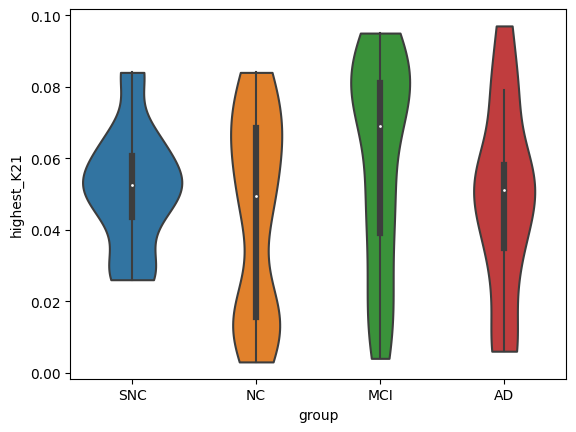

In [34]:
# plot the distribution of highest_K21 across different groups
seaborn.violinplot(x='group', y='highest_K21', data=local_inhibition, cut=0, bw=.4)

<Axes: xlabel='group', ylabel='highest_corr'>

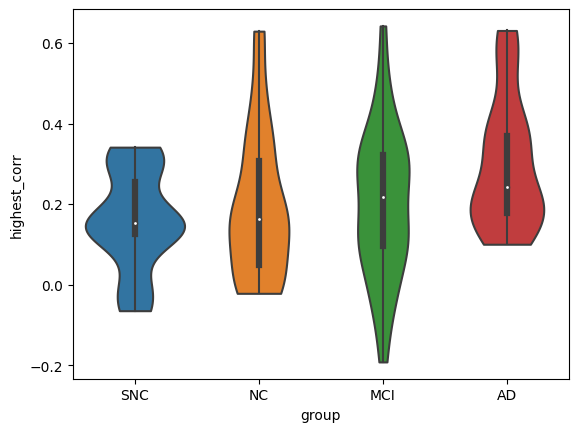

In [35]:
seaborn.violinplot(x='group', y='highest_corr', data=local_inhibition, cut=0, bw=0.4)

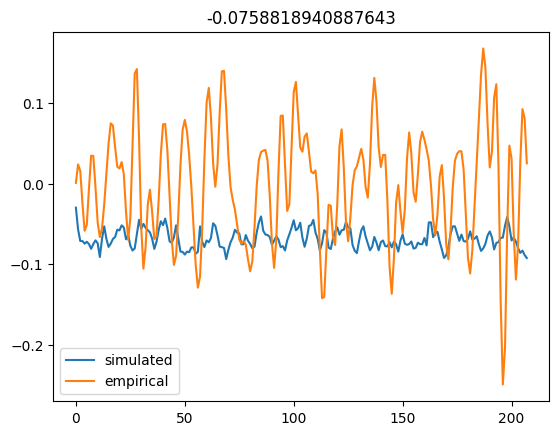

In [7]:
channel = 15
# check individual cases
group = "MCI"
caseid = "0578A"
K21 = local_inhibition[(local_inhibition.group==group) & (local_inhibition.caseid==caseid)].highest_K21.values[0]
case_path = pjoin(data_dir, group, caseid+'_'+str(K21)+'.csv')
case_ts = pd.read_csv(case_path)
# plot time series of all nodes
s_ts = preprocessing.normalize(np.array(case_ts.iloc[:,channel]).reshape(1,-1))
plt.plot(s_ts[0,:], label='simulated')



# empirical FC
mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
e_ts = pd.DataFrame(mat['ROISignals'])
e_ts = preprocessing.normalize(np.array(e_ts.iloc[:,channel]).reshape(1,-1))
plt.plot(e_ts[0,:], label='empirical')
plt.legend()
plt.title(f"{np.corrcoef(e_ts[0,:], s_ts[0,:])[0, 1]}")
plt.show()



In [49]:
# compare it with G optimal alone
data_dir = "/Users/yilewang/Desktop/Goptimal_data/corr_Goptimal"
def FC_fitting_only_Go(group, caseid, go, dir):
    subj_dir = pjoin(dir, group, caseid, group+"_"+caseid+"_"+str(go)+'.xlsx')
    # skip the first column when importing the data
    s_ts = pd.read_excel(subj_dir, names=range(1, 17))
    # calculate the simulated FC
    s_fc = s_ts.corr()
    # compare it to the empirical FC
    mat = scipy.io.loadmat(pjoin(eFC_dir, group+"-TS", caseid, "ROISignals_"+caseid+'.mat'))
    e_ts = pd.DataFrame(mat['ROISignals'])
    e_fc = e_ts.corr()
    # vectorize the lower triangle of the matrix
    s_fc_vec = np.tril(s_fc, k=-1).flatten()
    s_fc_vec = s_fc_vec[np.nonzero(s_fc_vec)[0]]
    e_fc_vec = np.tril(e_fc, k=-1).flatten()
    e_fc_vec = e_fc_vec[np.nonzero(e_fc_vec)[0]]
    # calculate the correlation coefficienv
    # s_fc_vec_nor = preprocessing.normalize(np.array(s_fc_vec).reshape(-1,1))[:,0]
    # e_fc_vec_nor = preprocessing.normalize(np.array(e_fc_vec).reshape(-1,1))[:,0]
    corr, p_value = scipy.stats.pearsonr(s_fc_vec, e_fc_vec)
    # iterate then I can have a plot for inidividuals.
    return corr, p_value



In [51]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')

# create a dataframe for all subjects
local_inhibition_only_go = pd.DataFrame(columns=['group', 'caseid', 'highest_corr', "highest_p"])
for i, j, go in zip(mega_data.group, mega_data.caseid, mega_data.Go):
    corr,p_value = FC_fitting_only_Go(i, j, go, data_dir)
    local_inhibition_only_go.loc[len(local_inhibition_only_go)] = [i, j, corr, p_value]

In [52]:
print(local_inhibition_only_go)
local_inhibition_only_go.to_csv('/Users/yilewang/Desktop/local_inhibition_only_go.csv', index=False)

   group caseid  highest_corr     highest_p
0    SNC  2820A      0.011169  9.036308e-01
1    SNC  3168A      0.333436  1.980753e-04
2    SNC  3358A     -0.070162  4.463699e-01
3    SNC  3610A      0.182160  4.645121e-02
4    SNC  4073A      0.023361  8.000689e-01
..   ...    ...           ...           ...
69    AD  3255A      0.282366  1.780312e-03
70    AD  4612A      0.135215  1.408916e-01
71    AD  5368A      0.172105  6.015838e-02
72    AD  5571A      0.093615  3.091521e-01
73    AD  7673A      0.599021  4.931113e-13

[74 rows x 4 columns]


<Axes: xlabel='group', ylabel='highest_corr'>

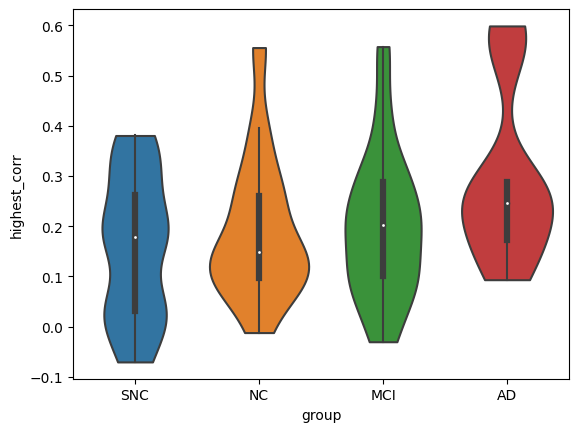

In [24]:
seaborn.violinplot(x='group', y='highest_corr', data=local_inhibition_only_go, cut=0, bw=0.4)

<Axes: xlabel='group', ylabel='highest_corr'>

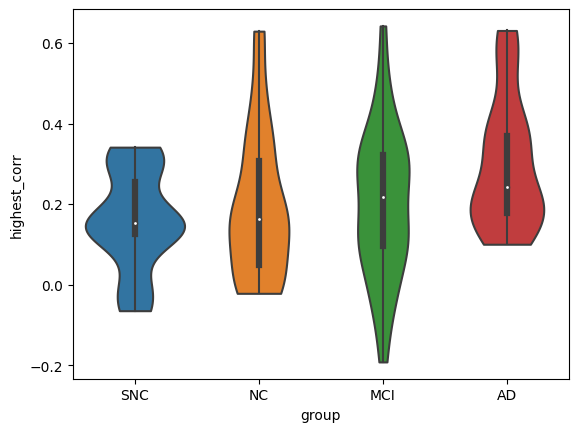

In [36]:
seaborn.violinplot(x='group', y='highest_corr', data=local_inhibition, cut=0, bw=0.4)

<Axes: xlabel='group', ylabel='highest_corr'>

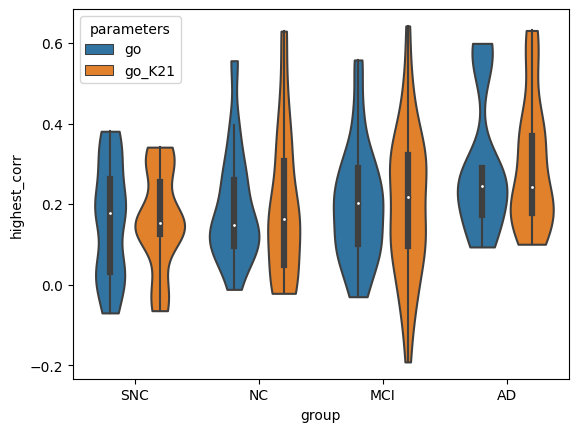

In [65]:
new_local = pd.read_excel("/Users/yilewang/Desktop/local_inhibition.xlsx", sheet_name='fc_go')
seaborn.violinplot(x='group', y='highest_corr', hue = "parameters", data=new_local, cut=0, bw=0.4)

<Axes: xlabel='group', ylabel='highest_corr'>

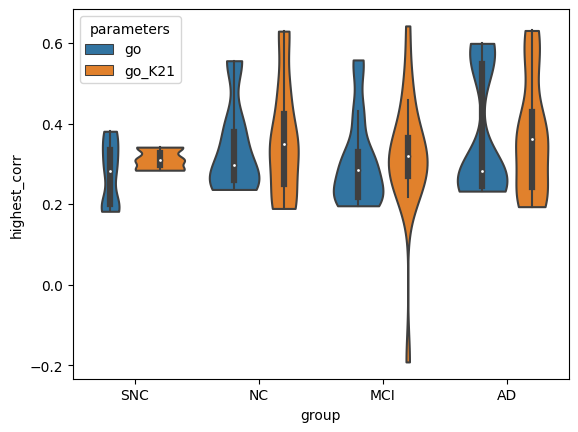

In [66]:
new_local = pd.read_excel("/Users/yilewang/Desktop/local_inhibition.xlsx", sheet_name='fc_go_delete')
seaborn.violinplot(x='group', y='highest_corr', hue = "parameters", data=new_local, cut=0, bw=0.4)

The P-value of the Permutation Test is: 0.7684231576842315


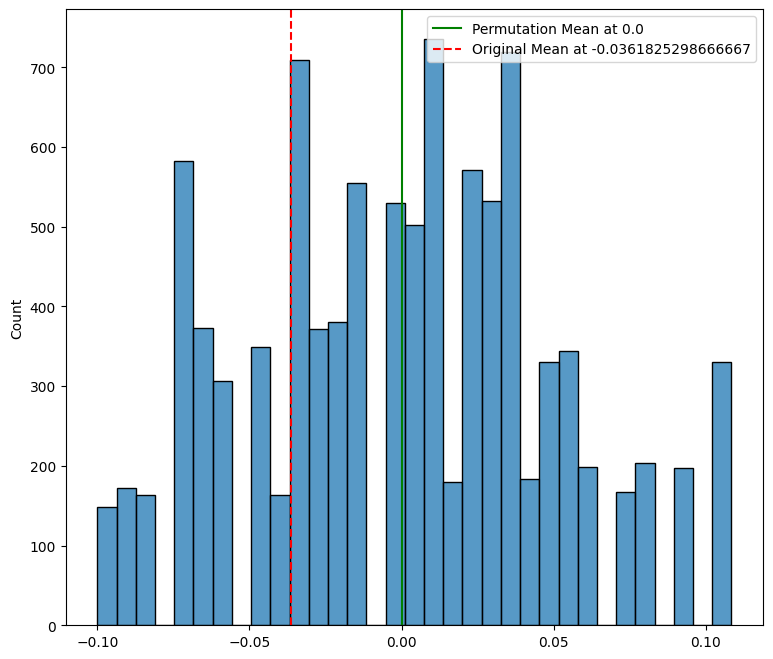

The P-value of the Permutation Test is: 0.5934406559344065


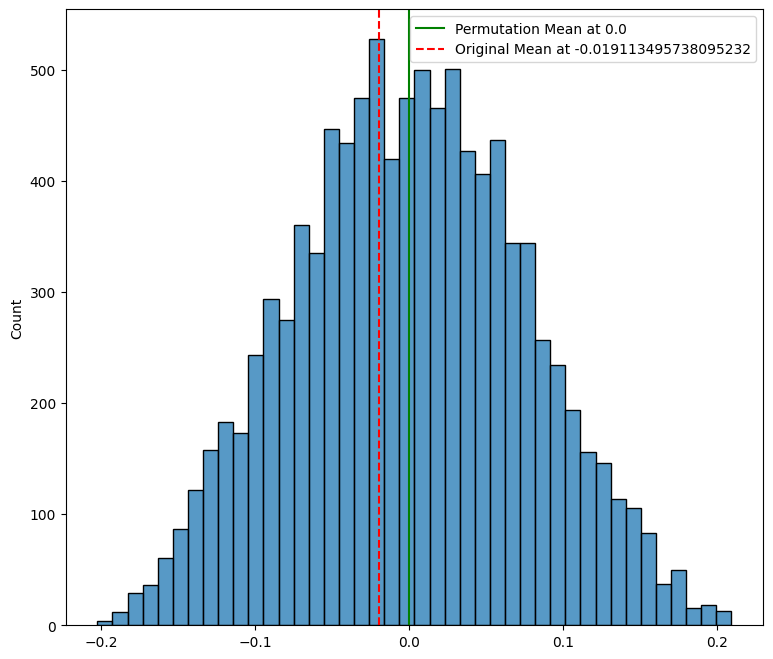

The P-value of the Permutation Test is: 0.6176382361763824


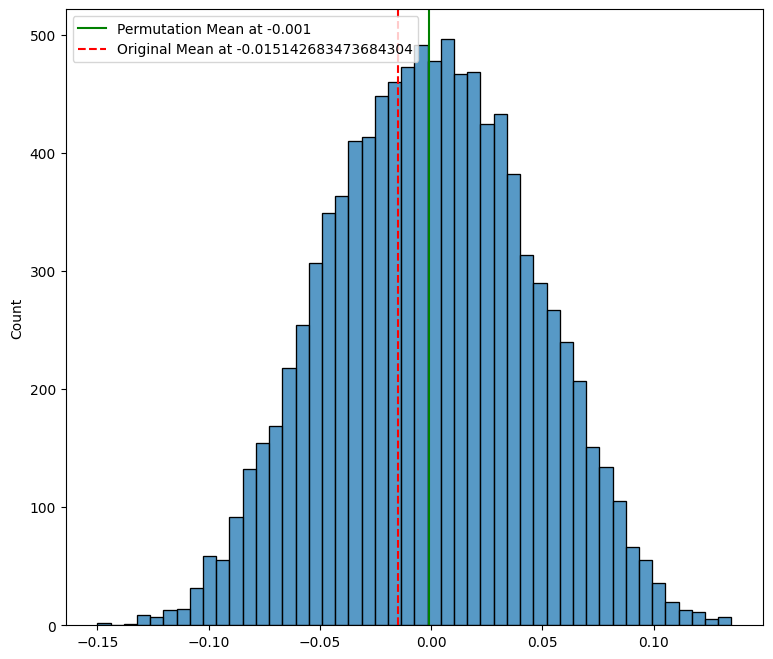

The P-value of the Permutation Test is: 0.5131486851314868


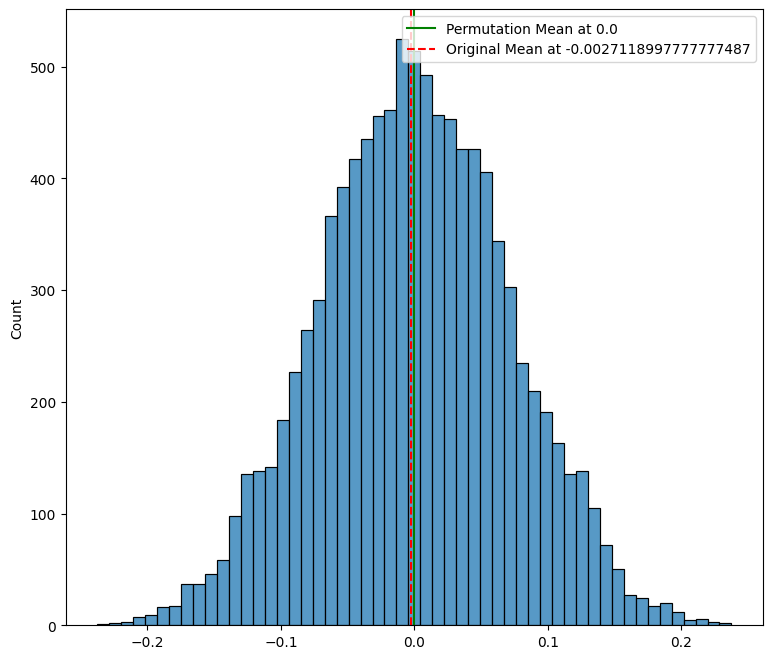

In [68]:
# permutation test, import tvbtools from /Users/yilewang/workspaces/tvbtools
import sys
sys.path.append('/Users/yilewang/workspaces')
from tvbtools.tools.statools import permutation_test
groups = ['SNC', 'NC', 'MCI', 'AD']


for i in groups:
    permutation_test(new_local.loc[(new_local["group"] == i) & (new_local["parameters"] == "go"), "highest_corr"], new_local.loc[(new_local["group"] == i) & (new_local["parameters"] == "go_K21"), "highest_corr"], 10000,True)

